In [1]:
# import packages 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import os 
import sys
import seaborn as sns
import scipy as sp
import scipy.stats as stats
from scipy.stats import norm
import xgboost
%matplotlib inline


# import pre-processing modules 
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_selection import SelectFromModel 

# import classifiers
# scale robust
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

# scale sensitive
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC

# import evaluation modules
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report

In [2]:
test_set = pd.read_csv(r"C:/Users/Yehonatan/PycharmProject/DS/projects/titanic/ignore/test.csv")
train_set = pd.read_csv(r"C:/Users/Yehonatan/PycharmProject/DS/projects/titanic/ignore/train.csv")
df_original = pd.concat([train_set,test_set], axis=0, ignore_index=True )

df_train = (train_set.copy()).rename(columns=str.lower)
df_test = (test_set.copy()).rename(columns=str.lower)

df = (df_original.copy()).rename(columns=str.lower)

In [3]:
# parse title and fam name from df 
def parse_name(df):
    last_name = df['name'].apply(lambda x : x.split(', ')[0])
    temp = df['name'].apply(lambda x : x.split(', ')[1])
    title = temp.apply(lambda x : x.split('.')[0])
    return title, last_name

def cat_to_numeric(df):
    cat_columns = df.select_dtypes(['object']).columns
    df[cat_columns] = df[cat_columns].apply(lambda x: pd.factorize(x)[0])
    return df 

def pvalue_filter(target_df, features_df, alpha): # returns a list of columns that are possible drop, p_val > alpha, corr, pval
    features_columns_names = list(features_df)
    target_column_name = list(target_df)
    features_np = features_df.to_numpy()
    target_np = target_df.to_numpy()
    drop_index = []
    p_val_list =[]
    corr_list = []
    
    for i in range(len(features_columns_names)):
        corr, p_val = sp.stats.pearsonr(features_np[:,i], target_np)
        corr_list.append(round(corr,3))
        if p_val > alpha:           # accept the null hypothesis, no statisitcal significance  
            drop_index.append(i)
            p_val_list.append(p_val)
            
    drop_col = [features_columns_names[i] for i in drop_index]
    return drop_col, corr_list, p_val_list

def random_age(df,category):
    df = df 
    df_children = df[df["age"] < 15]
    
    if category == 'boys':
        
        df_children_boys = df_children[df_children['sex'] == 'male']
        mean_boys = round(df_children_boys['age'].mean(),2)
        std_boys = round(df_children_boys['age'].std(),2)
        low_boys = mean_boys - std_boys
        high_boys  =  mean_boys + std_boys
        random_age_boys = np.random.uniform(low_boys, high_boys, size=1)
        return  random_age_boys
    
    elif category == 'girls':
        
        df_children_girls = df_children[df_children['sex'] == 'female']
        mean_girls = round(df_children_girls['age'].mean(),2)
        std_girls = round(df_children_girls['age'].std(),2)
        low_girls = mean_girls - std_girls
        high_girls  =  mean_girls + std_girls
        random_age_girls = np.random.uniform(low_girls, high_girls, size=1)
        return random_age_girls
    
    elif category == 'male':
        
        df_male = df[df['sex'] == 'male']
        mean_male = round(df_male['age'].mean(),2)
        std_male = round(df_male['age'].std(),2)
        low_male = mean_male - std_male
        high_male =  mean_male + std_male
        random_age_male = np.random.uniform(low_male, high_male, size=1)
        return  random_age_male
    
    elif category == 'female':
        
        df_female = df[df['sex'] == 'female']
        mean_female = round(df_female['age'].mean(),2)
        std_female = round(df_female['age'].std(),2)
        low_female = mean_female - std_female
        high_female =  mean_female + std_female
        random_age_female = np.random.uniform(low_female, high_female, size=1)
        return  random_age_female
    
    if category == 'children':
    
        mean_children = round(df_children['age'].mean(),2)
        std_children = round(df_children['age'].std(),2)
        low_children = mean_children - std_children
        high_children  =  mean_children + std_children
        random_age_children = np.random.uniform(low_children, high_children, size=1)
        return random_age_children

def features_corr_filter(features, corr_cutoff): 
    corr = features.corr()
    columns = np.full((corr.shape[0],), True, dtype=bool) # create boolean filter 

    for i in range(corr.shape[0]):
        for j in range(i+1, corr.shape[0]):
            if corr.iloc[i,j] >= corr_cutoff:
                columns[j] = False

    rejected_columns = x_train.columns[np.invert(columns)]
    #print('reject',rejected_columns)
    selected_columns = x_train.columns[columns]
    #print('selected',selected_columns)
    return selected_columns, rejected_columns


In [4]:
# work on df nan and then concat with original df_train and sort by ID
age_nan = df[df['age'].isna()]
#age_nan.info()
#age_nan = age_nan.sort_values(by=['sex'],ascending=True)
#age_nan = age_nan.sort_values(by=['sibsp'],ascending=False).reset_index(drop=True)
print('df  age nans',df['age'].isna().sum())



df  age nans 263


In [5]:
###### Deal with masters  ############################################
title, last_name = parse_name(age_nan)
title = title[title == 'Master']
master_index = title.index.to_numpy()

for i in master_index:
    df.at[i,'age'] = random_age(df, 'boys') 

age_nan = df[df['age'].isna()] # update the age_nan
print('df  age nans1',df['age'].isna().sum())

####### DEAL  with lone passengers ############################################

l_p_t = age_nan[age_nan['sibsp'] == 0]
lone_pass = l_p_t[l_p_t['parch'] == 0] # passengers who travel alone and cant determine their age by relatives

lone_pass_male = lone_pass[lone_pass['sex'] == 'male']
lone_pass_female = lone_pass[lone_pass['sex'] == 'female']

l_p_m_index = (lone_pass_male.index).to_numpy()
l_p_f_index = (lone_pass_female.index).to_numpy()

for m in l_p_m_index:
    df.at[m,'age'] = random_age(df, 'male') 
    
for f in l_p_f_index:
    df.at[f,'age'] = random_age(df, 'female') 

age_nan = df[df['age'].isna()] # update the age_nan
print('df  age nans2',df['age'].isna().sum())


########## ONE companion ############################################################
# one companion in nan df # assign the age of the companion tot the nan 
one_comp_nan = age_nan[age_nan['parch'] == 0] 
one_comp_nan = one_comp_nan[one_comp_nan['sibsp'] == 1]
title_ocn, last_name_ocn = parse_name(one_comp_nan)
ocn_index = (title_ocn.index).to_numpy()


one_comp = df[df['parch'] == 0] # one companion in general df may contain istself. but some companions are both nan in age
one_comp = one_comp[one_comp['sibsp'] == 1]
#one_comp = one_comp[~one_comp['age'].isna()]
title_oc, last_name_oc = parse_name(one_comp)
oc_index = (title_oc.index).to_numpy()

for l in range(len(one_comp_nan)):
    for i in range(len(one_comp)):
        
        if (list(last_name_ocn)[l] == list(last_name_oc)[i] and ocn_index[l] != oc_index[i]): #ensures same last name and not same person
            
            if df.at[oc_index[i],'age'] != float('nan'): #if the companion has an age
                df.at[ocn_index[l],'age'] =  df.at[oc_index[i],'age'] 
            
            if list(title_ocn)[l] == 'Mrs' : # she and her husbnad are adults and get the adult random age
                df.at[ocn_index[l],'age'] = random_age(df, 'female') 
                df.at[oc_index[i],'age'] = random_age(df, 'male') 
            
            # she is a miss and I assume that travels with a sibling so get girls random age
             
            if list(title_ocn)[l] == 'Miss': 
                df.at[ocn_index[l],'age'] = random_age(df, 'girls') 
                df.at[oc_index[i],'age'] = random_age(df, 'children') 
            
            if list(title_ocn)[l] == 'Mr' and list(title_oc)[i] != 'Mrs':
                df.at[ocn_index[l],'age'] = random_age(df, 'boys') 
                df.at[oc_index[i],'age'] = random_age(df, 'children') 


age_nan = df[df['age'].isna()] # update the age_nan
print('df  age nans3',df['age'].isna().sum())

# notice there are only two famillies with 3 siblings travelling together I assume they are all young <15.
three_siblings = age_nan[age_nan['parch'] == 0] 
three_siblings = three_siblings[three_siblings['sibsp'] == 2]
index_temp = three_siblings.index.to_numpy()
for i in index_temp:
    df.at[i,'age'] = random_age(df, 'children') 

age_nan = df[df['age'].isna()] # update the age_nan

########### Hand fill age nans #######################################################


# hand fill, thought it will be quicker than thinking about an algo  
#parents
df.at[1233, 'age'] = random_age(df, 'male') 
df.at[1256, 'age'] = random_age(df, 'female') 
#kids
sages = df[df['ticket'] == 'CA. 2343']
sages = sages[sages['age'].isna()]

index_temp = sages.index.to_numpy()
for i in index_temp:
    df.at[i,'age'] = random_age(df, 'children')
age_nan = df[df['age'].isna()] # update the age_nan

df.at[1023, 'age'] = random_age(df, 'female')
lebfre = df[df['ticket'] == '4133']
lebfre = lebfre[lebfre['age'].isna()]
index_temp = lebfre.index.to_numpy()

for i in index_temp:
    df.at[i,'age'] = random_age(df, 'children')
age_nan = df[df['age'].isna()] # update the age_nan

#jhonston
#parents
df.at[783, 'age'] = random_age(df, 'male')
df.at[924, 'age'] = random_age(df, 'female')
df.at[888,'age'] = random_age(df, 'children')
age_nan = df[df['age'].isna()] # update the age_nan

df.at[1024, 'age'] = random_age(df, 'male') # has no sibsp as I looked
df.at[128, 'age'] = random_age(df, 'children')
df.at[593, 'age'] = random_age(df, 'children')
#index = [166,533,593,1116,140]
df.at[166, 'age'] = random_age(df, 'female')
df.at[533, 'age'] = random_age(df, 'female')
df.at[593, 'age'] = random_age(df, 'female')
df.at[1116, 'age'] = random_age(df, 'female')
df.at[140, 'age'] = random_age(df, 'female')
age_nan = df[df['age'].isna()] # update the age_nan


df  age nans1 255
df  age nans2 56
df  age nans3 29


# cabin nans


In [6]:
# deal with cabin nan by comparing the ticket number 
# small number of nans but I know for certain that they get the correct cabin
cabin = df[~df['cabin'].isna()]
cabin_nan =  df[df['cabin'].isna()]
print('df  cabin nans',df['cabin'].isna().sum())

for t in range(len(cabin['ticket'])):
    for n in range(len(cabin_nan['ticket'])):
        if cabin['ticket'].iloc[t] == cabin_nan['ticket'].iloc[n] :
           
            index = cabin['passengerid'].iloc[t] - 1    
            index_nan = cabin_nan['passengerid'].iloc[n] - 1 
            if index != index_nan:

                # update the value of cabin_nan in the df
                df.at[index_nan,'cabin'] = df.at[index,'cabin']



cabin_nan =  df[df['cabin'].isna()] # update cabin_nan
print('df cabin nans updated',len(cabin_nan))    


# handle single men and single women in seconde and thied class 

s_t_class_cabin = cabin[cabin['pclass'] != 1] 
single_temp = s_t_class_cabin[s_t_class_cabin['sibsp'] == 0]
single_cabin = single_temp[single_temp['parch'] == 0]

s_t_class_cabin_female = single_cabin[single_cabin['sex'] == 'female'] # single 2 3 class female

s_t_class_cabin_nan = cabin_nan[cabin_nan['pclass'] != 1]
single_temp = s_t_class_cabin_nan[s_t_class_cabin_nan['sibsp'] == 0]
single_cabin_nan = single_temp[single_temp['parch'] == 0]


s_t_class_cabin_nan_female = single_cabin_nan[single_cabin_nan['sex'] == 'female']

# deal with female. compare fare  
#why separated - coz generlizing the cabin nan in male might be different   

for t in range(len(s_t_class_cabin_female)):
    for n in range(len(s_t_class_cabin_nan_female)):
        if s_t_class_cabin_female['fare'].iloc[t] == s_t_class_cabin_nan_female['fare'].iloc[n] :
            
            pclass_cabin = s_t_class_cabin_female['pclass'].iloc[t]              
            pclass_cabin_nan = s_t_class_cabin_nan_female['pclass'].iloc[n]
            index = s_t_class_cabin_female['passengerid'].iloc[t] - 1    
            index_nan = s_t_class_cabin_nan_female['passengerid'].iloc[n] - 1 
            
            if index != index_nan and pclass_cabin == pclass_cabin_nan : # make sure the deduction about cabin doesnt cross pclass

                df.at[index_nan,'cabin'] = df.at[index,'cabin'] # update the value of cabin_nan in the df

cabin_nan =  df[df['cabin'].isna()] 
print('df cabin nans updated',len(cabin_nan))    

# deal with the rest 

for p in range(len(cabin_nan)):
    
    # third class
    if cabin_nan['pclass'].iloc[p] == 3 and cabin_nan['sex'].iloc[p] == 'male':
        index = cabin_nan['passengerid'].iloc[p] - 1
        p = np.random.randint(low=1, high=101, size=1, dtype=int)[0]
        if p <= 13:
            df.at[index,'cabin'] = 'l'
        elif p > 13:
                df.at[index,'cabin'] = 'D'
    
    if cabin_nan['pclass'].iloc[p] == 3 and cabin_nan['sex'].iloc[p] == 'female':
        index = cabin_nan['passengerid'].iloc[p] - 1
        p = np.random.randint(low=1, high=101, size=1, dtype=int)[0]
        if p < 50:
            df.at[index,'cabin'] = 'l'
        elif p >= 50:
                df.at[index,'cabin'] = 'D'
                
    # second class
    if cabin_nan['pclass'].iloc[p] == 2 and cabin_nan['sex'].iloc[p] == 'male':
        index = cabin_nan['passengerid'].iloc[p] - 1
        p = np.random.randint(low=1, high=101, size=1, dtype=int)[0]
        if p <= 13:
            df.at[index,'cabin'] = 'l'
        elif p > 13:
                df.at[index,'cabin'] = 'D'
    
    if cabin_nan['pclass'].iloc[p] == 2 and cabin_nan['sex'].iloc[p] == 'female':
        index = cabin_nan['passengerid'].iloc[p] - 1
        p = np.random.randint(low=1, high=101, size=1, dtype=int)[0]
        if p <= 93:
            df.at[index,'cabin'] = 'l'
        elif p >= 93:
                df.at[index,'cabin'] = 'D'
                
    # first class
    if cabin_nan['pclass'].iloc[p] == 1 and cabin_nan['sex'].iloc[p] == 'male':
        index = cabin_nan['passengerid'].iloc[p] - 1
        p = np.random.randint(low=1, high=101, size=1, dtype=int)[0]
        if p <= 22:
            df.at[index,'cabin'] = 'l'
        elif p > 22:
                df.at[index,'cabin'] = 'D'
    
    if cabin_nan['pclass'].iloc[p] == 1 and cabin_nan['sex'].iloc[p] == 'female':
        index = cabin_nan['passengerid'].iloc[p] - 1
        df.at[index,'cabin'] = 'l'
        
        
        
cabin_nan =  df[df['cabin'].isna()] # update cabin_nan
print('df cabin nans updated',len(cabin_nan)) 

df  cabin nans 1014
df cabin nans updated 998
df cabin nans updated 981
df cabin nans updated 0


## other nans 

In [7]:
# fill fare nan as the average of 3 class . 

t_class = df[df['pclass'] == 3]
t_class_mean = t_class['fare'].mean()
df.at[1043, 'fare'] = t_class_mean
# df['cabin'] = df['cabin'].fillna(5)

# fill nan embarked to be an class of itself
df.at[61, 'embarked'] = 'M'
df.at[829, 'embarked'] = 'M'

In [8]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   passengerid  1309 non-null   int64  
 1   survived     891 non-null    float64
 2   pclass       1309 non-null   int64  
 3   name         1309 non-null   object 
 4   sex          1309 non-null   object 
 5   age          1309 non-null   float64
 6   sibsp        1309 non-null   int64  
 7   parch        1309 non-null   int64  
 8   ticket       1309 non-null   object 
 9   fare         1309 non-null   float64
 10  cabin        1309 non-null   object 
 11  embarked     1309 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


# categorize 

In [9]:
df = cat_to_numeric(df)

In [10]:
# divide back into train test sets 
df_train = df.iloc[:890,:]
df_test = df.iloc[891:,:]

#df_train.info()
#df_test.info()

## check corr

In [11]:
corr_mat = df_train.corr()
corr_mat['survived'].sort_values(ascending=False)

survived       1.000000
sex            0.543053
cabin          0.295534
fare           0.256995
embarked       0.120736
parch          0.081248
passengerid   -0.003479
name          -0.003479
sibsp         -0.035760
ticket        -0.045727
age           -0.070249
pclass        -0.337996
Name: survived, dtype: float64

# train

In [12]:
x_train = df_train.drop(columns = ['survived','passengerid'])
y_train = df_train['survived']

x_test = df_test.drop(columns = ['survived','passengerid'])

drop_col, corr_list, p_val_list = pvalue_filter(y_train, x_train, 0.05)
x_train = x_train.drop(drop_col, axis=1)
x_test = x_test.drop(drop_col, axis=1)

print(drop_col)

['name', 'sibsp', 'ticket']


In [13]:
selected_columns, rejected_columns = features_corr_filter(x_train, 0.9)
print(selected_columns)
print(rejected_columns)


x_train = x_train[selected_columns]
x_test = x_test[selected_columns]

Index(['pclass', 'sex', 'age', 'parch', 'fare', 'cabin', 'embarked'], dtype='object')
Index([], dtype='object')


In [14]:
# scaler = StandardScaler()

# x_train = scaler.fit_transform(x_train)

# x_test = df_test.drop(columns =  ['survived', 'passengerid'])
# x_test = scaler.transform(x_test)


In [26]:
# rf
clf = RandomForestClassifier(n_estimators= 200, max_depth=2, random_state=9)
clf.fit(x_train, y_train)
y_train_pred = clf.predict(x_train)

In [29]:
clf = LogisticRegression(random_state=9, max_iter=500, solver = 'newton-cg') 
clf.fit(x_train, y_train)
y_train_pred = clf.predict(x_train)

In [91]:
clf = GaussianNB()
clf.fit(x_train, y_train)
y_train_pred = clf.predict(x_train)

In [110]:
clf = AdaBoostClassifier(n_estimators=70, random_state=0)
clf.fit(x_train, y_train)
y_train_pred = clf.predict(x_train)

In [179]:
clf = GradientBoostingClassifier(n_estimators=40, learning_rate=0.25,
                                 max_depth=2, random_state=0)
clf.fit(x_train, y_train)
y_train_pred = clf.predict(x_train)

In [18]:
clf =  XGBClassifier(n_estimators=100, max_depth=5 ,learning_rate=0.5, objective='binary:logistic',gamma=3)
clf.fit(x_train, y_train)
y_train_pred = clf.predict(x_train)

In [19]:
clf

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=3, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.5, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=5, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [30]:
precision, recall, f_1, support = precision_recall_fscore_support(y_train, y_train_pred, average='binary')
accuracy = accuracy_score(y_train, y_train_pred)
print('accuracy :', np.round(accuracy,3))
print('precision :', np.round(precision,3))
print('recall :', np.round(recall,3))
print('f_score :', np.round(f_1,3))

accuracy : 0.796
precision : 0.74
recall : 0.722
f_score : 0.731


In [31]:
cv_5_accuracy = cross_val_score(clf, x_train , y_train, cv=5, scoring='accuracy')
cv_5_precision = cross_val_score(clf, x_train , y_train, cv=5, scoring='precision')
cv_5_recall = cross_val_score(clf, x_train , y_train, cv=5, scoring='recall')
cv_5_f1 = cross_val_score(clf, x_train , y_train, cv=5, scoring='f1')

print('cv_avg_accuracy :', np.round(cv_5_accuracy.mean(),3))
print('cv_avg_precision', np.round(cv_5_precision.mean(),3))
print('cv_avg_recall', np.round(cv_5_recall.mean(),3))
print('cv_avg_fscore :', np.round(cv_5_f1.mean(),3))

cv_avg_accuracy : 0.793
cv_avg_precision 0.734
cv_avg_recall 0.725
cv_avg_fscore : 0.729


<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

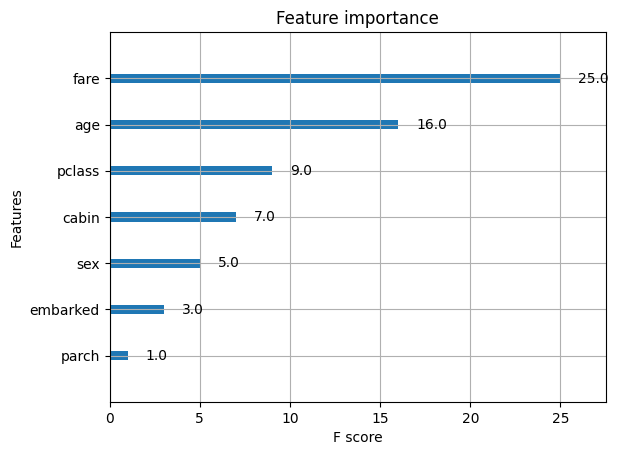

In [22]:
xgboost.plot_importance(clf,ax=plt.gca())

# Test

In [32]:
y_test_pred = clf.predict(x_test)
y_test_pred = y_test_pred.astype(int)

In [33]:
passenger_id = df_test['passengerid'].values
submission_df = pd.DataFrame({'Passengerid': passenger_id, 'Survived': y_test_pred})
submission_df.to_csv('titanic_pred_25.csv', index = False)
